In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import astropy.units as u
import seaborn as sns
import pystan
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sns.set_context('poster')
sns.set_palette('colorblind')


import pymc3 as pm


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class model_reg():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi = p

        # Unpack background parameters
        loga = aphi[0]
        logb = aphi[1]
        logc = aphi[2]
        logd = aphi[3]
        logj = aphi[4]
        logk = aphi[5]
        white = bphi[0]
        scale = bphi[1]
        nyq = bphi[2]
        
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.): 
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu

    def f0(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()
        
    def harvey(self, a, b, c):
        harvey = 0.9*tt.sqr(a)/b/(1.0 + tt.pow((self.f/b), c))
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return tt.sqr((tt.sin(x)/x))

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(tt.pow(10, loga), tt.pow(10, logb), 4.) \
                        +  self.harvey(tt.pow(10, logc), tt.pow(10, logd), 4.) \
                        +  self.harvey(tt.pow(10, logj), tt.pow(10, logk), 2.))\
                        +  white
        return background              

# Set up the simulated data

In [3]:
### Build the range

nmodes = 10
nbase = 13
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

### Build the frequencies

deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

mod = model_reg(ff, n0_, n1_, n2_, deltanu_)

init_f = [numax_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

### Reset model for new frequency range

mod = model_reg(f, n0_, n1_, n2_, deltanu_)

### Build the linewidths

def kernel(n, rho, L):
    return rho**2 * np.exp(-0.5 * np.subtract.outer(n,n)**2 / L**2)

m_ = .5
c_ = .5
rho_ = 0.1
L_ = 0.3

fs = np.concatenate((f0_, f1_, f2_))
fs -= fs.min()
nf = fs/fs.max()
mu_ = m_ * nf + c_

Sigma_ = kernel(nf, rho_, L_)

lng0_ = np.random.multivariate_normal(mu_, Sigma_)
widths = [np.exp(lng0_)[0:len(f0_)],
          np.exp(lng0_)[len(f0_):len(f0_)+len(f1_)],
          np.exp(lng0_)[len(f0_)+len(f1_):]]

nf_ = nf[:,None]

### Build the mode amplitudes

w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
sigmaA_ = .2
amps = [mod.A0(f0_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A1(f1_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A2(f2_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_]

### Build the background

labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
aphi_ =[   1.6,   2.6,   1.6,   3.0,   1.7,   0.5]
bphi_ = [0.4,     1., nyq]
phi_sigma = np.genfromtxt('phi_sigma.txt')
aphi_cholesky = np.linalg.cholesky(phi_sigma[:6,:6])
bphi_sigma = np.sqrt(np.diag(phi_sigma)[6:])

### Construct the model

split_ = 1.
incl_ = np.pi/4.
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       aphi_,                           # background parameters
       bphi_ ]

## First construction of the regular build

In [4]:
import time

In [5]:
t0 = time.time()
mod = model_reg(f, n0_, n1_, n2_, deltanu_)
t1 = time.time()
print(f'First construction took: {(t1-t0):.2f} s')

First construction took: 0.00 s


In [6]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'First call took: {(t1-t0):.2f} s')

First call took: 0.25 s


In [7]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'Second call took: {(t1-t0):.2f} s')

Second call took: 0.26 s


In [8]:
t0 = time.time()
p = mod.model(init_m, theano=False)
t1 = time.time()
print(f'Non-theano call took: {(t1-t0):.2f} s')

Non-theano call took: 113.67 s


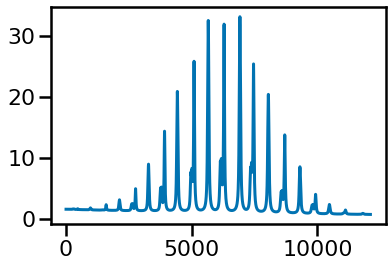

In [9]:
plt.plot(p)

# Adapted build

In [10]:
class model_if():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i, l, m):
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return tt.sqr(tt.cos(i))
            if np.abs(m) == 1:
                return 0.5 * tt.sqr(tt.sin(i))
        if l == 2:
            if m == 0:
                return 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.))
            if np.abs(m) ==1:
                return (3./8.) * tt.sqr(tt.sin(2*i))
            if np.abs(m) == 2:
                return (3./8.) * tt.sin(i)**4

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l,abs(m)), 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi = p

        # Unpack background parameters
        loga = aphi[0]
        logb = aphi[1]
        logc = aphi[2]
        logd = aphi[3]
        logj = aphi[4]
        logk = aphi[5]
        white = bphi[0]
        scale = bphi[1]
        nyq = bphi[2]
        
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    def harvey(self, a, b, c):
        harvey = 0.9*tt.sqr(a)/b/(1.0 + tt.pow((self.f/b), c))
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return tt.sqr((tt.sin(x)/x))

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(tt.pow(10, loga), tt.pow(10, logb), 4.) \
                        +  self.harvey(tt.pow(10, logc), tt.pow(10, logd), 4.) \
                        +  self.harvey(tt.pow(10, logj), tt.pow(10, logk), 2.))\
                        +  white
        return background              

In [11]:
t0 = time.time()
mod = model_if(f, n0_, n1_, n2_, deltanu_)
t1 = time.time()
print(f'First construction took: {(t1-t0):.2f} s')

First construction took: 0.00 s


In [12]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'First call took: {(t1-t0):.2f} s')

First call took: 0.28 s


In [13]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'Second call took: {(t1-t0):.2f} s')

Second call took: 0.28 s


In [14]:
t0 = time.time()
p = mod.model(init_m, theano=False)
t1 = time.time()
print(f'Non-theano call took: {(t1-t0):.2f} s')

Non-theano call took: 22.75 s


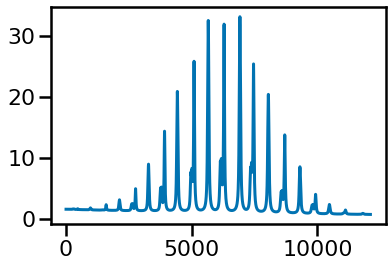

In [15]:
plt.plot(p)

# Numpy build

In [16]:
class model_np():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i, l, m):
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l,abs(m)), 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi = p

        # Unpack background parameters
        loga = aphi[0]
        logb = aphi[1]
        logc = aphi[2]
        logd = aphi[3]
        logj = aphi[4]
        logk = aphi[5]
        white = bphi[0]
        scale = bphi[1]
        nyq = bphi[2]
        
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    def harvey(self, a, b, c):
        harvey = 0.9*a**2/b/(1.0 + (self.f/b)**c)
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(10**loga, 10**logb, 4.) \
                        +  self.harvey(10**logc, 10**logd, 4.) \
                        +  self.harvey(10**logj, 10**logk, 2.))\
                        +  white
        return background              

In [17]:
t0 = time.time()
mod = model_np(f, n0_, n1_, n2_, deltanu_)
t1 = time.time()
print(f'First construction took: {(t1-t0):.2f} s')

First construction took: 0.00 s


In [18]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'First call took: {(t1-t0):.2f} s')

First call took: 0.02 s


In [19]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'Second call took: {(t1-t0):.2f} s')

Second call took: 0.01 s


In [20]:
t0 = time.time()
p = mod.model(init_m, theano=False)
t1 = time.time()
print(f'Non-theano call took: {(t1-t0):.2f} s')

AttributeError: 'numpy.ndarray' object has no attribute 'eval'

In [ ]:
plt.plot(p)

## Np math, tensorflow epsilon

In [16]:
class model_np():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i, l, m):
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l,abs(m)), 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi = p

        # Unpack background parameters
        loga = aphi[0]
        logb = aphi[1]
        logc = aphi[2]
        logd = aphi[3]
        logj = aphi[4]
        logk = aphi[5]
        white = bphi[0]
        scale = bphi[1]
        nyq = bphi[2]
        
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    def harvey(self, a, b, c):
        harvey = 0.9*a**2/b/(1.0 + (self.f/b)**c)
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(10**loga, 10**logb, 4.) \
                        +  self.harvey(10**logc, 10**logd, 4.) \
                        +  self.harvey(10**logj, 10**logk, 2.))\
                        +  white
        return background              

In [17]:
t0 = time.time()
mod = model_np(f, n0_, n1_, n2_, deltanu_)
t1 = time.time()
print(f'First construction took: {(t1-t0):.2f} s')

First construction took: 0.00 s


In [18]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'First call took: {(t1-t0):.2f} s')

First call took: 0.02 s


In [19]:
t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'Second call took: {(t1-t0):.2f} s')

Second call took: 0.01 s


In [20]:
t0 = time.time()
p = mod.model(init_m, theano=False)
t1 = time.time()
print(f'Non-theano call took: {(t1-t0):.2f} s')

AttributeError: 'numpy.ndarray' object has no attribute 'eval'

In [ ]:
plt.plot(p)

In [25]:
class model_np():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], np.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * np.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3 * np.cos(i)**2 - 1)**2)
        eps2 = tt.set_subtensor(eps2[1], (3/8)*np.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3/8) * np.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)       
        return eps
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi = p

        # Unpack background parameters
        loga = aphi[0]
        logb = aphi[1]
        logc = aphi[2]
        logd = aphi[3]
        logj = aphi[4]
        logk = aphi[5]
        white = bphi[0]
        scale = bphi[1]
        nyq = bphi[2]
        
        # Calculate the modes
        eps = self.epsilon(i)
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    def harvey(self, a, b, c):
        harvey = 0.9*a**2/b/(1.0 + (self.f/b)**c)
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(10**loga, 10**logb, 4.) \
                        +  self.harvey(10**logc, 10**logd, 4.) \
                        +  self.harvey(10**logj, 10**logk, 2.))\
                        +  white
        return background              

In [26]:
t0 = time.time()
mod = model_np(f, n0_, n1_, n2_, deltanu_)
t1 = time.time()
print(f'First construction took: {(t1-t0):.2f} s')


First construction took: 0.00 s


In [27]:

t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'First call took: {(t1-t0):.2f} s')


First call took: 0.13 s


In [28]:

t0 = time.time()
p = mod.model(init_m, theano=True)
t1 = time.time()
print(f'Second call took: {(t1-t0):.2f} s')


Second call took: 0.15 s


Non-theano call took: 17.11 s


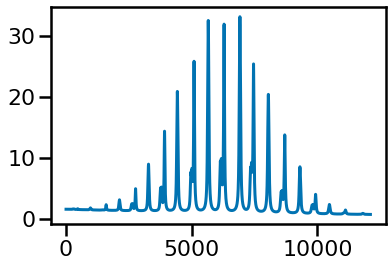

In [29]:

t0 = time.time()
p = mod.model(init_m, theano=False)
t1 = time.time()
print(f'Non-theano call took: {(t1-t0):.2f} s')

plt.plot(p)